In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import gc
from skimage.util import random_noise


In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [107]:
# # Load the dataset
# file_name = os.path.join(GOOGLE_DRIVE_PATH, 'fer2013.csv')
# df = pd.read_csv(file_name)

# im=df['pixels']
# df.head(10)

In [108]:
import pandas as pd
import gdown

def read_data(file_id):
    # Construct the full Google Drive URL
    url = f'https://drive.google.com/uc?id={file_id}'

    # Define a local filename to save the file
    output_file = 'data.csv'

    # Use gdown to download the file
    gdown.download(url, output_file, quiet=False)

    # Load the file using pandas
    data = pd.read_csv(output_file)
    return data

In [109]:
# Example usage
file_id = '14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S'
df = read_data(file_id)
im=df['pixels']
df.head(10)

Downloading...
From (original): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S
From (redirected): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S&confirm=t&uuid=85d1d034-de0f-4e50-ba56-16003685e399
To: /content/data.csv
100%|██████████| 301M/301M [00:01<00:00, 151MB/s]


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


Adding labels and images(pixel values) in respective array

In [110]:
import numpy as np
import gdown

def getData(file_id):
    # Construct the direct download URL using the file_id
    url = f'https://drive.google.com/uc?id={file_id}'

    # Define a local filename to save the file
    local_file = 'data.csv'

    # Download the file using gdown
    gdown.download(url, local_file, quiet=False)

    # Process the file
    Y = []
    X = []
    first = True
    for line in open(local_file):
        if first:
            first = False
        else:
            row = line.strip().split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X), np.array(Y)
    return X, Y

# Example usage
file_id = '14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S'
X, Y = getData(file_id)
print(X.shape, Y.shape)


Downloading...
From (original): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S
From (redirected): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S&confirm=t&uuid=2af65dd6-46c8-492e-a692-96c6fbc2437f
To: /content/data.csv
100%|██████████| 301M/301M [00:06<00:00, 47.3MB/s]


(35887, 2304) (35887,)


In [111]:
X, Y = getData(file_id)
num_class = len(set(Y))
#print(num_class)

Downloading...
From (original): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S
From (redirected): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S&confirm=t&uuid=8ea112ea-ff3d-428f-a819-6674991a2093
To: /content/data.csv
100%|██████████| 301M/301M [00:02<00:00, 124MB/s]


Extracting Data and splitting train and test

In [112]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [113]:
x_train.shape

(28709, 2304)

In [114]:
distinct_labels = df['emotion'].unique()
print("Distinct Labels:", distinct_labels)

Distinct Labels: [0 2 4 6 3 5 1]


Data Preprocessing

In [115]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))  # adapt this if using `channels_first` image data format

#adding noise in data
noise_factor = 0.15

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
x_train_noisy = random_noise(x_train, mode="s&p",clip=True, amount=noise_factor)
x_test_noisy = random_noise(x_test, mode="s&p",clip=True, amount=noise_factor)


#x_train_noisy = x_train + noise_factor * np.random.poisson(lam=(0,1), size=x_train.shape)
#x_test_noisy = x_test + noise_factor * np.random.poisson(lam=(0,1), size=x_test.shape)

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Taking 100 images seperate for final testing

In [116]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

In [117]:
x_test_noisy.shape

(7078, 48, 48, 1)

Visualization of 10 Data

In [118]:
n = 10

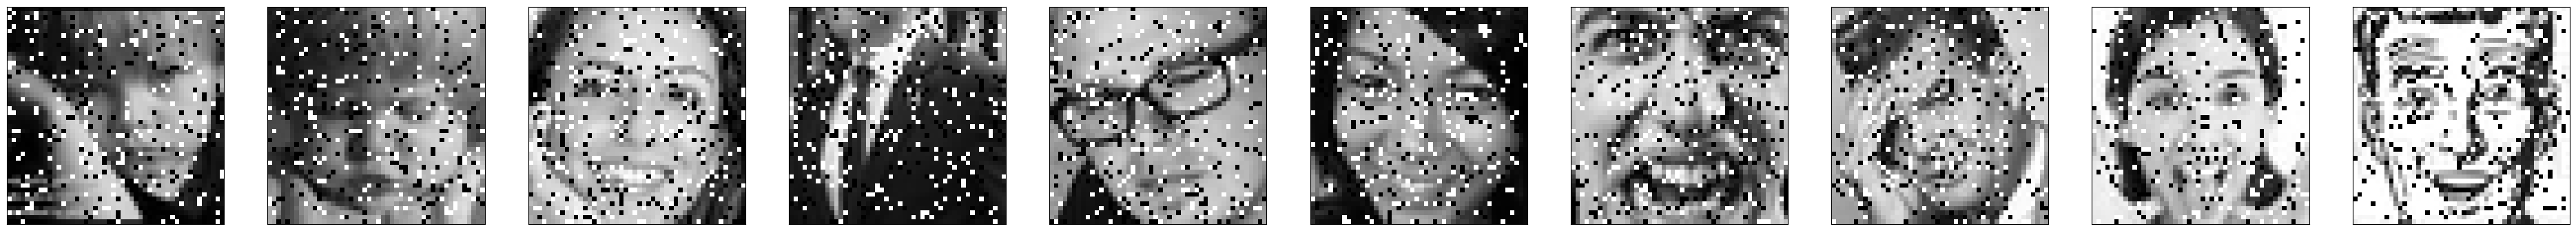

In [119]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [120]:
train_dataset = TensorDataset(torch.tensor(x_train_noisy, dtype=torch.float32).permute(0, 3, 1, 2),
                               torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2))
test_dataset = TensorDataset(torch.tensor(x_test_noisy, dtype=torch.float32).permute(0, 3, 1, 2),
                              torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Construction of Model

In [121]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)  # Output: (B, 64, H, W)
        enc2 = self.enc2(enc1)  # Output: (B, 128, H/2, W/2)

        # Bottleneck
        bottleneck = self.bottleneck(enc2)  # Output: (B, 256, H/2, W/2)

        # Decoder
        dec2 = self.dec2(bottleneck)  # Output: (B, 128, H, W)

        # Concatenate with encoder output (skip connection)
        dec1 = self.dec1(torch.cat([dec2, enc1], dim=1))  # Output: (B, 64, H, W)

        # Final output layer
        return self.final(dec1)


In [122]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input channels are 2 (noisy image + clean/generated image)
            nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 1),
            nn.Sigmoid()  # Binary classification: real (1) or fake (0)
        )

    def forward(self, noisy, clean_or_generated):
        # Concatenate input (noisy) and output (clean/generated) along the channel dimension
        combined = torch.cat([noisy, clean_or_generated], dim=1)
        return self.model(combined)


In [123]:
# Initialize models, optimizers, and loss functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)  # Updated to UNetDiscriminator

# Define loss functions
adversarial_loss = nn.BCELoss()  # Binary cross-entropy loss for discriminator
mse_loss = nn.MSELoss()  # Mean squared error loss for generator

# Define optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Training Model

In [124]:
# Training loop
epochs = 10
lam = 100

for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch = 0, 0
    generator.train()
    for x_batch, y_batch in tqdm(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Train discriminator
        disc_optimizer.zero_grad()
        real_labels = torch.ones(x_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

        real_loss = adversarial_loss(discriminator(x_batch, y_batch), real_labels)
        fake_loss = adversarial_loss(discriminator(x_batch, generator(x_batch).detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        disc_optimizer.step()

        # Train generator
        gen_optimizer.zero_grad()
        fake_images = generator(x_batch)
        fake_loss_gan = adversarial_loss(discriminator(x_batch, fake_images), real_labels)
        fake_loss_mse = mse_loss(fake_images, y_batch)
        g_loss = fake_loss_gan + lam * fake_loss_mse
        g_loss.backward()
        gen_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Generator Loss: {g_loss_epoch/len(train_loader):.4f}, Discriminator Loss: {d_loss_epoch/len(train_loader):.4f}")



100%|██████████| 449/449 [00:54<00:00,  8.24it/s]


Epoch 1/10, Generator Loss: 1.7053, Discriminator Loss: 0.6760


100%|██████████| 449/449 [00:53<00:00,  8.35it/s]


Epoch 2/10, Generator Loss: 1.2834, Discriminator Loss: 0.6730


100%|██████████| 449/449 [00:54<00:00,  8.29it/s]


Epoch 3/10, Generator Loss: 0.9840, Discriminator Loss: 0.6882


100%|██████████| 449/449 [00:54<00:00,  8.30it/s]


Epoch 4/10, Generator Loss: 0.9065, Discriminator Loss: 0.6906


100%|██████████| 449/449 [00:54<00:00,  8.27it/s]


Epoch 5/10, Generator Loss: 0.8701, Discriminator Loss: 0.6917


100%|██████████| 449/449 [00:53<00:00,  8.32it/s]


Epoch 6/10, Generator Loss: 0.8389, Discriminator Loss: 0.6923


100%|██████████| 449/449 [00:54<00:00,  8.31it/s]


Epoch 7/10, Generator Loss: 0.8162, Discriminator Loss: 0.6946


100%|██████████| 449/449 [00:54<00:00,  8.31it/s]


Epoch 8/10, Generator Loss: 0.8017, Discriminator Loss: 0.6945


100%|██████████| 449/449 [00:54<00:00,  8.29it/s]


Epoch 9/10, Generator Loss: 0.7890, Discriminator Loss: 0.6954


100%|██████████| 449/449 [00:54<00:00,  8.30it/s]


Epoch 10/10, Generator Loss: 0.7777, Discriminator Loss: 0.6956


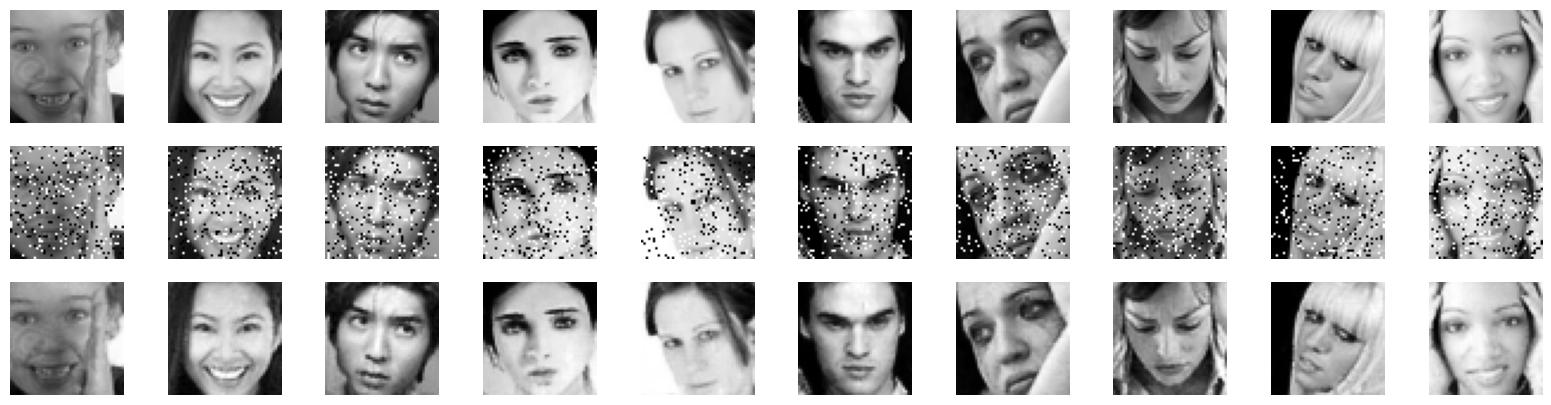

In [125]:
# Evaluate and visualize results
generator.eval()
with torch.no_grad():
    predictions = []
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        predictions.append(generator(x_batch).cpu())
    predictions = torch.cat(predictions)


n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [126]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Initialize lists to store metrics
psnr_values = []
ssim_values = []
mse_values = []

# Compute metrics for each image
for i in range(len(predictions)):
    # Convert tensors to NumPy arrays
    original = x_test[i].squeeze()  # Already a NumPy array
    generated = predictions[i].squeeze().numpy()  # Convert tensor to NumPy array

    # MSE
    mse_value = np.mean((original - generated) ** 2)
    mse_values.append(mse_value)

    # PSNR
    psnr_value = psnr(original, generated, data_range=1)  # Assuming normalized [0, 1] range
    psnr_values.append(psnr_value)

    # SSIM
    ssim_value = ssim(original, generated, data_range=1)
    ssim_values.append(ssim_value)

# Compute average metrics
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)
avg_mse = sum(mse_values) / len(mse_values)

# Print results
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average MSE: {avg_mse:.6f}")


Average PSNR: 32.31
Average SSIM: 0.9707
Average MSE: 0.000671
